In [1]:
from bs4 import BeautifulSoup
import requests
import re
from selenium import webdriver
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report,precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import shap

from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB
import xgboost

# KNN Model
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


# Read in the data collected and do some cleaning.

In [2]:
base_dat = pd.read_pickle("./Metis_Project_3_Bankruptcy/FINAL_data.pkl")
# somewhere along the collection we got a few duplicate documents. We should remove them.
base_dat = base_dat.drop_duplicates(subset=['CIK','Filings','Filing Date'])

In [3]:
# combine the name fields for companies in the bankrupt set and non-bankrupt set.
base_dat['Name'] = base_dat['Name'].combine_first(base_dat['debtorname'])

#Combine these columns since they are the same.
base_dat['total stockholders equity']= base_dat['total stockholders’ equity']+base_dat['total stockholders equity']

#Drop some unnecessary columns that are leftover from the original datasets.
base_dat.drop(['debtorname','Exchange', 'SIC', 'Business', 'Incorporated',
       'IRS', '1','level_0', 'index', 'Unnamed: 0', 'industry',
       'industrygroup','disposition', '363sale', 'duration', 'incstate',
       'districtfiled', 'cityfiled', 'forumshopping', 'filingparty',
       'plantype', 'employees', 'businesssurvival', 'refiled',
       'headquarterscity', 'datedisposed', 'assetsize', 'employeesize',
       'annualsales', 'assetsmillions', 'debtorsattorney',
       'matches', 'EDGAR_name', 'Unnamed: 29','Format','banruptcy_6_mo'], axis='columns', inplace=True)



In [4]:
# Set NaN days to bankruptcy as 0, these are non-bankrupt companies.
base_dat['d_to_bankruptcy'] = base_dat['d_to_bankruptcy'].fillna(0)

# Filter out filing data that occurs after a company has filed for bankruptcy.
mask = (base_dat['d_to_bankruptcy']>=0)
base_dat = base_dat[mask]

# if the filing is dated within 365 days of the company filing for bankruptcy, it is flagged as 1, the rest are 0.
base_dat['bankruptcy_1_yr'] = np.where((base_dat['d_to_bankruptcy']<=365) & (~base_dat['chapteratfiling'].isna()),1,0)
base_dat = base_dat.reset_index() 
base_dat['bankruptcy_1_yr'].value_counts()

0    36977
1      643
Name: bankruptcy_1_yr, dtype: int64

In [5]:
# a List of our primary variables for prediction which will make it wasier to reference in the future.

X_cols=['current assets', 'cash and cash equivalents',
       'accounts receivable net', 'prepaid expenses', 'other current assets',
       'total current assets', 'property and equipment net', 'goodwill',
       'other assets', 'total assets', 'current liabilities',
       'accounts payable', 'accrued expenses',
       'current maturities of longterm debt', 'total current liabilities',
       'other longterm liabilities','accumulated deficit', 'accumulated other comprehensive loss',
       'inventories', 'restricted cash',
       'prepaid expenses and other current assets', 'deferred income taxes',
       'other noncurrent liabilities', 'total liabilities',
       'retained earnings', 'total stockholders equity',
       'total liabilities and stockholders equity', 'preferred stock',
       'current portion of longterm debt', 'other liabilities',
       'additional paidin capital', 'total stockholders’ equity',
       'total liabilities and stockholders’ equity', 'longterm debt',
       'accumulated other comprehensive income', 'noncontrolling interest',
       'intangible assets net', 'accounts payable and accrued expenses',
       'assets held for sale', 'other noncurrent assets', 'common stock',
       'noncontrolling interests', 'total equity',
       'total liabilities and equity', 'property plant and equipment net',
       'other longterm assets', 'deferred revenue', 'other',
       'accrued interest','inventory', 'asset retirement obligations', 'retained deficit',
       'accounts payable and accrued liabilities', 'accrued liabilities',
       'accounts receivable', 'other current liabilities']


In [6]:
# drop rows where all of the columns we need are empty.
base_dat = base_dat.dropna(how='all',subset=X_cols, inplace=False).reset_index()

In [7]:
#This takes a long time to run.

# Some of our data is in thousands while some is not. We need to make sure that individual company's financial 
# data is scalled correctly. I will look at each row and column and check if the value is 100x larger than 
# the company median value for the column. This should catch unscalled data and correct it.

for col in X_cols:
    base_dat[col]=[(base_dat.loc[amt,col]/1000) if (base_dat.loc[amt,col]>(np.median(base_dat[base_dat.CIK==base_dat.loc[amt,'CIK']][col])*100)) else (base_dat.loc[amt,col]) for amt in range(0,len(base_dat))]

# Adding some Features.

Originally I added these after the fact but because we need all of the data together to calculate some of the over time metrics. I will calculate them all before splitting the data.

In [8]:
base_dat['liquidity_ratio'] = np.nanmean(base_dat[['current assets','total current assets']].replace(0,np.nan),axis=1) / np.nanmean(base_dat[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1)
base_dat['debt_to_equity'] = np.nanmean(base_dat[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1) / base_dat['total stockholders equity']
base_dat['debt_ratio'] =   np.nanmean(base_dat[['longterm debt','current portion of longterm debt']].replace(0,np.nan),axis=1)  /np.nanmean(base_dat[['current assets','total current assets']].replace(0,np.nan),axis=1)
base_dat.replace(np.inf, 0, inplace=True)
X_cols = X_cols+['liquidity_ratio','debt_to_equity','debt_ratio']

Mean of empty slice
Mean of empty slice
Mean of empty slice


0    34129
1      443
Name: bankruptcy_1_yr, dtype: int64

In [9]:
# Add difference over time values. First we need to order the data by company filing type and date.
base_dat = base_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)

#make file type change columns
for col in X_cols:
    base_dat[col+'_diff']= np.where(base_dat['Filings']==base_dat['Filings'].shift(1),base_dat[col]-base_dat[col].shift(1),0)


# We will do the same as above but it will return a cumulative summary of the difference over time.
for col in X_cols:
    base_dat[col+'_cumsum']= np.where(base_dat['Filings']==base_dat['Filings'].shift(1), base_dat[col+'_diff'].shift(1),0)

base_dat = base_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)
for col in X_cols:
    for l in range(1,len(base_dat)):
        base_dat.loc[l,col+'_cumsum']= np.where(base_dat.loc[l,'Filings']==base_dat.loc[l-1,'Filings'], base_dat.loc[l-1,col+'_cumsum']+base_dat.loc[l,col+'_diff'],0)


In [10]:
#holdout set 2020 pd.
mask = (pd.DatetimeIndex(base_dat['datefiled']).year==2020)
holdout=base_dat[mask]

#keep the rest of the set
base_dat = base_dat[~mask]

mask2 = (pd.DatetimeIndex(base_dat['datefiled']).year==2019)
#make a test set of companies that filed in 2019
test=base_dat[mask2]

# a train set of companies that filed nefore 2019
train=base_dat[~mask2]

In [11]:
print('Holdout: \n',holdout['bankruptcy_1_yr'].value_counts())

Holdout: 
 0    244
1    148
Name: bankruptcy_1_yr, dtype: int64


In [12]:
print('Holdout: \n',test['bankruptcy_1_yr'].value_counts())

Holdout: 
 0    115
1     66
Name: bankruptcy_1_yr, dtype: int64


In [13]:
print('Holdout: \n',train['bankruptcy_1_yr'].value_counts())

Holdout: 
 0    34014
1      377
Name: bankruptcy_1_yr, dtype: int64


# Baseline model only looking at original features plus debt ratios we calculated

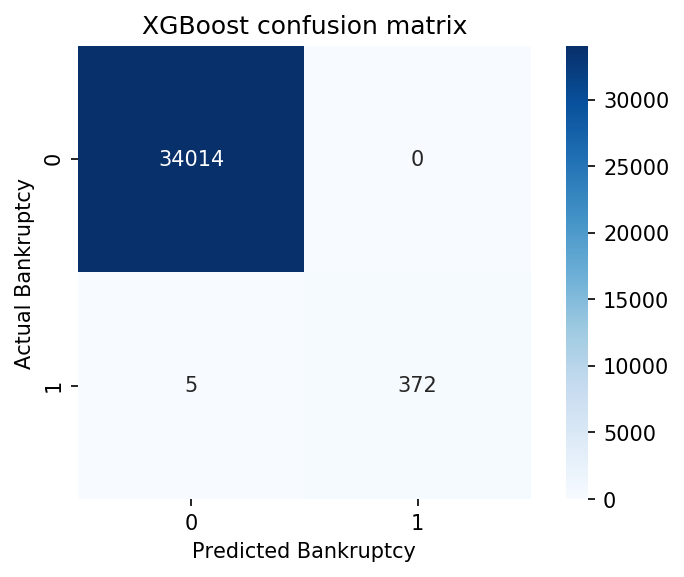

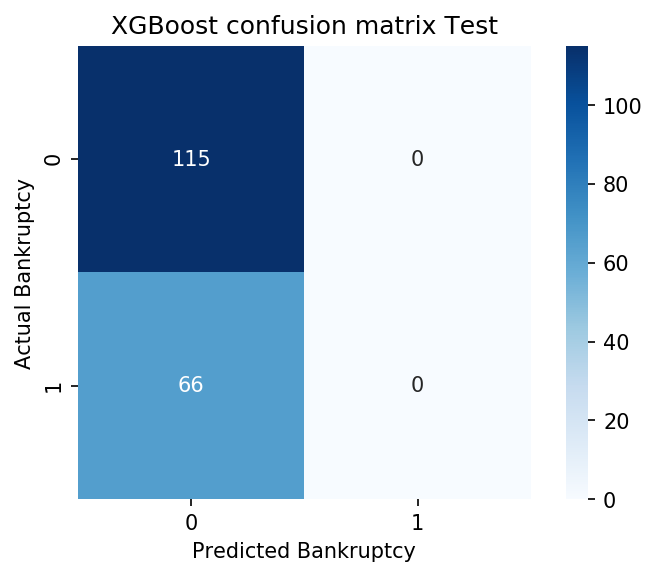

In [14]:
X_train = train[X_cols]
y_train = train['bankruptcy_1_yr']

X_test = test[X_cols]
y_test = test['bankruptcy_1_yr']

xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train )

# Print confusion matrix xgb model
baseline_confusion = confusion_matrix(y_train , xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

# Print confusion matrix for test data
baseline_confusion_test = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion_test, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix Test');


# Try with additional features.

_diff columns added

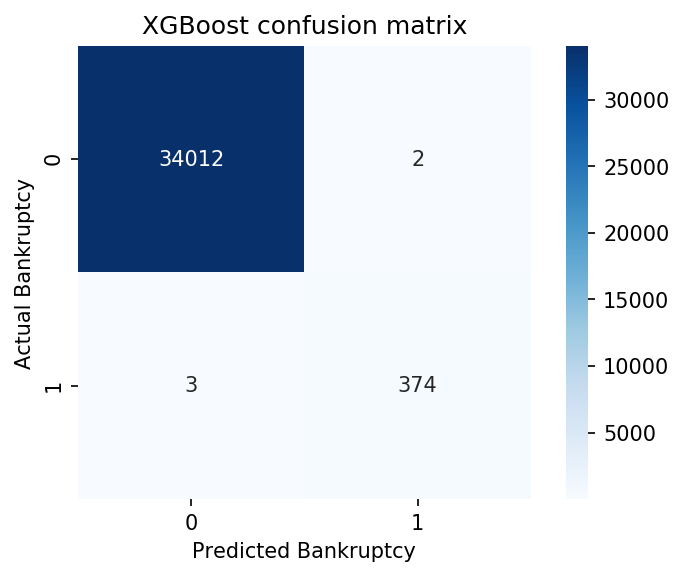

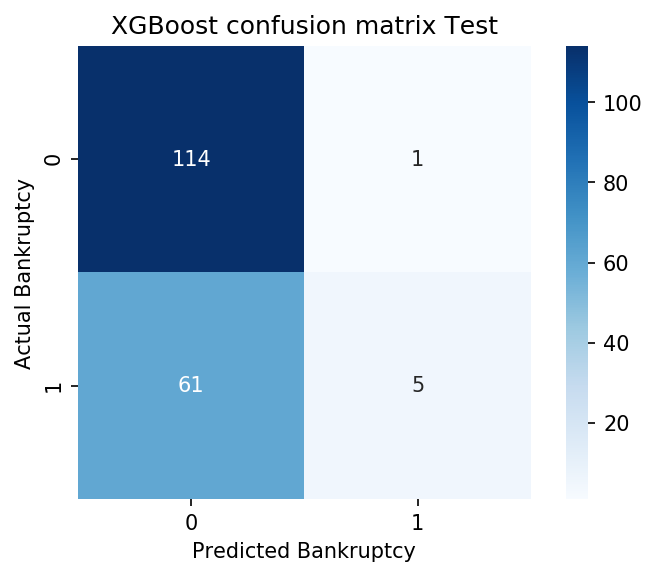

In [143]:
diff_cols = [s + '_diff' for s in X_cols]

X_train = train[X_cols+diff_cols]
y_train = train['bankruptcy_1_yr']

X_test = test[X_cols+diff_cols]
y_test = test['bankruptcy_1_yr']

xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train )

# Print confusion matrix xgb model
baseline_confusion = confusion_matrix(y_train , xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

# Print confusion matrix for test data
baseline_confusion_test = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion_test, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix Test');

Try with the cummulative sum columns.

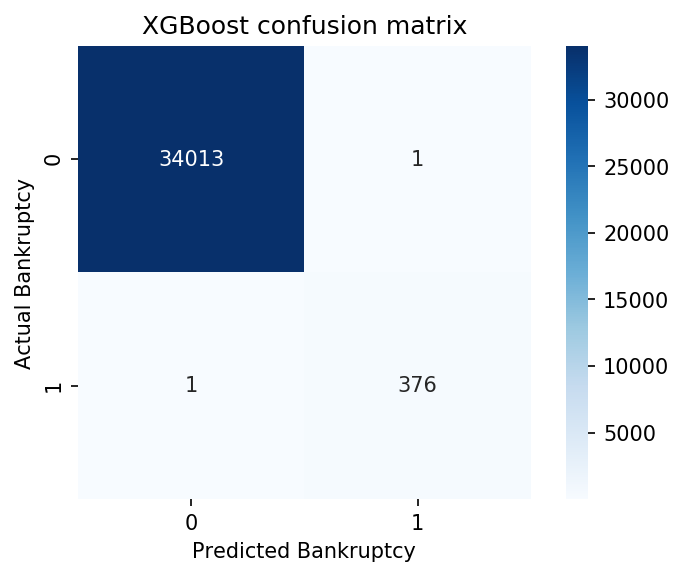

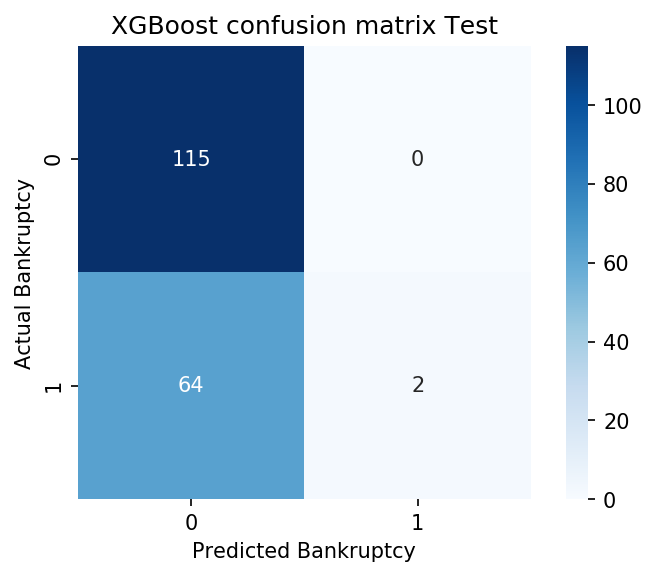

In [144]:
#diff_cols = [s + '_diff' for s in X_cols]
cum_cols = [s + '_cumsum' for s in X_cols]

X_train = train[X_cols+cum_cols]
y_train = train['bankruptcy_1_yr']

X_test = test[X_cols+cum_cols]
y_test = test['bankruptcy_1_yr']

xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train )

# Print confusion matrix xgb model
baseline_confusion = confusion_matrix(y_train , xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

# Print confusion matrix for test data
baseline_confusion_test = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion_test, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix Test');

Try with both.

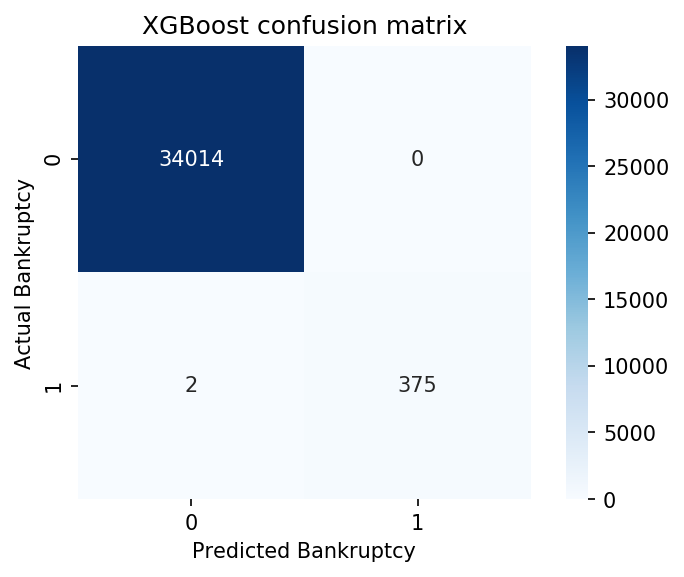

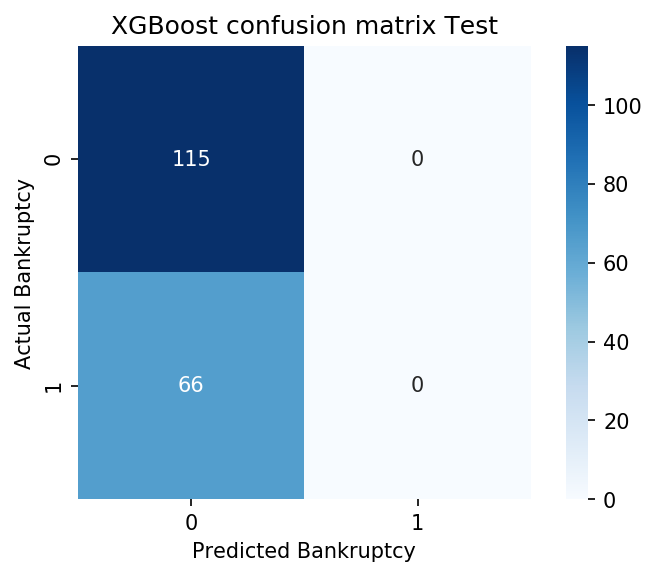

In [24]:
diff_cols = [s + '_diff' for s in X_cols]
cum_cols = [s + '_cumsum' for s in X_cols]

X_train = train[X_cols+cum_cols+diff_cols]
y_train = train['bankruptcy_1_yr']

X_test = test[X_cols+cum_cols+diff_cols]
y_test = test['bankruptcy_1_yr']

xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train )

# Print confusion matrix xgb model
baseline_confusion = confusion_matrix(y_train , xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

# Print confusion matrix for test data
baseline_confusion_test = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(baseline_confusion_test, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix Test');

It seems like our model might be over fitting on the training set making it less useful for general cases. There are ways to try and work around that in parameter tuning, but first I'd like to try dealing with some of the data balance issue.

# Using Smote for balancing.

A paper I had found [here](https://arxiv.org/pdf/1106.1813.pdf) explains that in the case of highly imbalanced data it can be best to undersample the majority class while expanding the minority class using SMOTE. They also mention this approach can be particularly effective if the cost of an incorrect majority classification is less costly than and minority misclassification. In our case, staying away from companies that don't end up going bankrupt is not a huge cost to us, however incorrectly predicting a company won't, and investing in it before it does can be very costly.

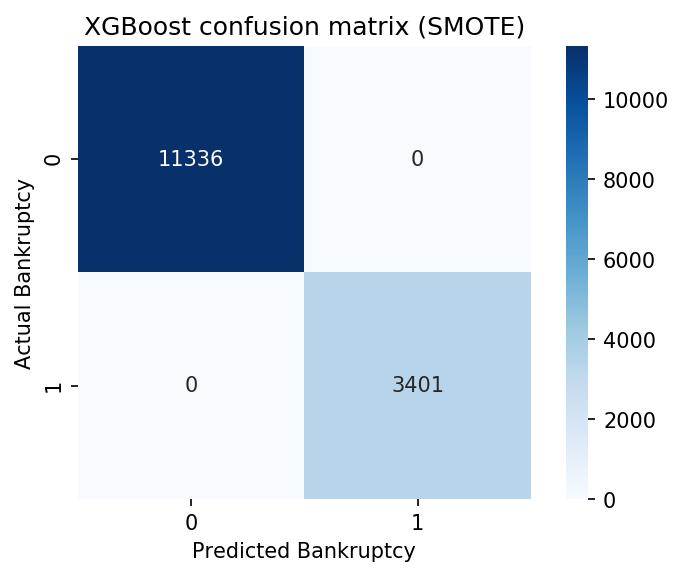

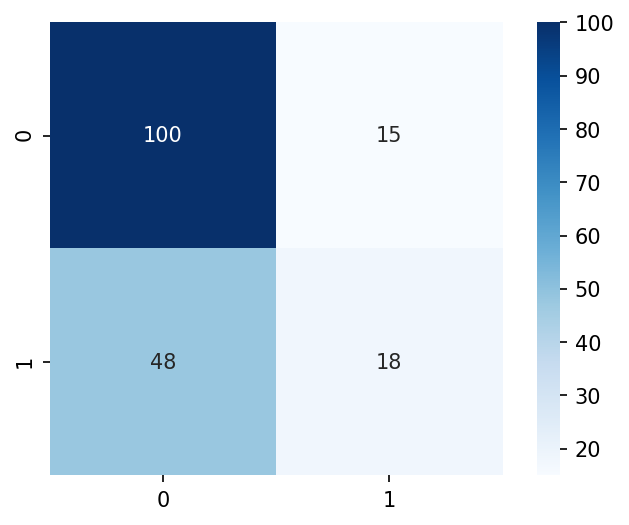

In [25]:

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)
X_test =  X_test.fillna(0)

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)

#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_train_smote,y_train_smote, early_stopping_rounds=150,eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)],eval_metric='auc',verbose=False )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (SMOTE)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

This is a bit better. We do have a lot of features now which might not be necessary.

Text(0.5, 0, 'Xgboost Feature Importance')

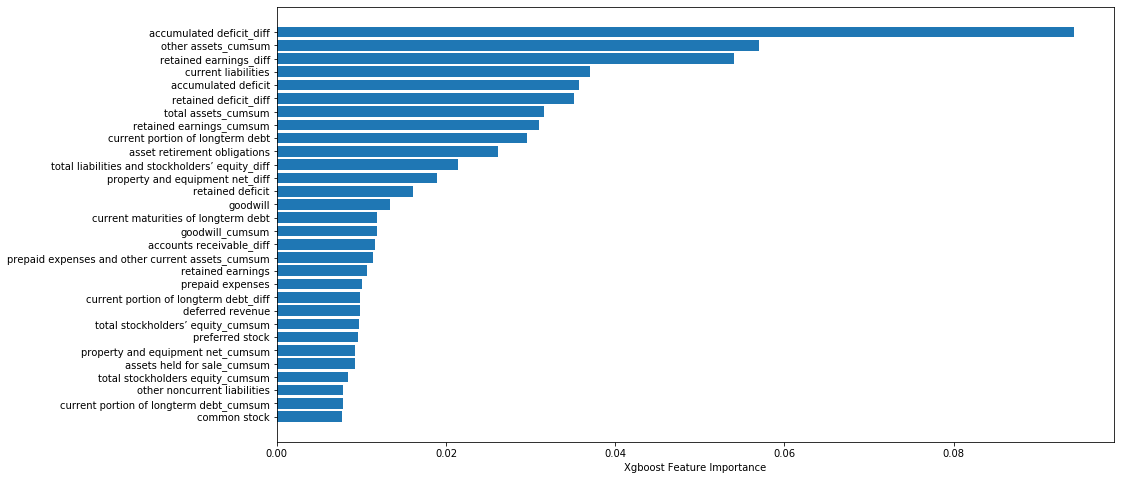

In [26]:
fig, ax = plt.subplots(figsize=(15, 8))
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx[-30:]], xgb.feature_importances_[sorted_idx[-30:]])
plt.xlabel("Xgboost Feature Importance")

In [27]:
short_cols=X_train.columns[sorted_idx[-30:]]

I'd like to try the same model above but just with the top 30 features above.

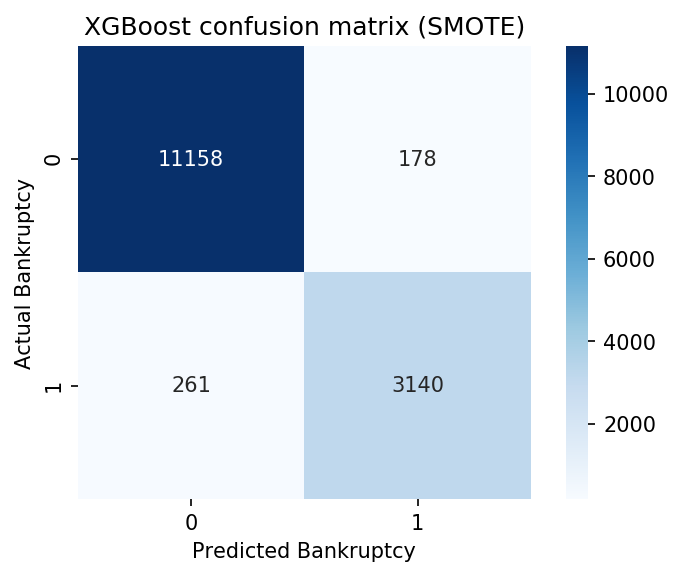

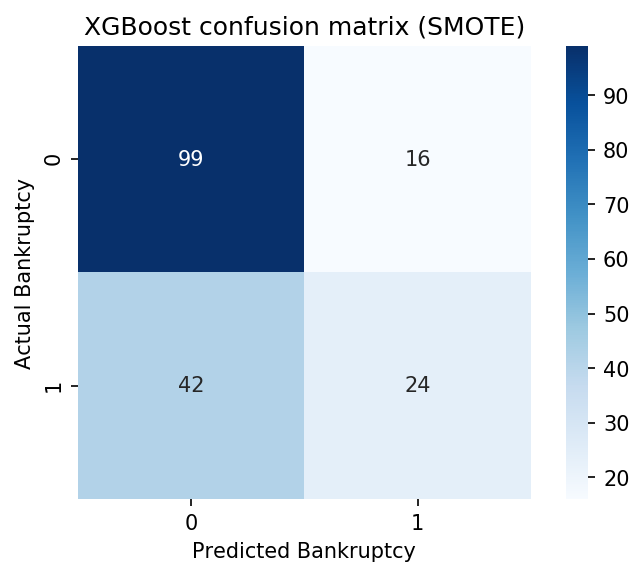

In [22]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)


X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s[short_cols], y_train)

#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_train_smote,y_train_smote, early_stopping_rounds=500,eval_set=[(X_train_smote, y_train_smote), (X_test[short_cols], y_test)],eval_metric='auc',verbose=False )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (SMOTE)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (SMOTE)');

The model doesn't improve but it is much less complex. I might try and stick to these columns or at least try both.

# Now that we have decided to impute 0s and use SMOTE balancing, we can also try other models.

KNN ROC AUC score =  0.561133069828722


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR ROC AUC score =  0.6731225296442688
SVC ROC AUC score =  0.6616600790513835
GRM ROC AUC score =  0.5044795783926219
Decision Tree ROC AUC score =  0.5927536231884057
Decision Tree ROC AUC score =  0.7206192358366272
Decision Tree ROC AUC score =  0.7206192358366272


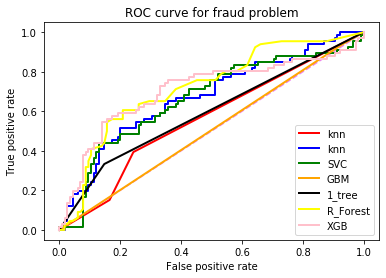

In [133]:
# Try various models with all columns.

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)

###### KNN ########
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train_smote, y_train_smote)

train_preds = knn.score(X_train_smote, y_train_smote)
test_preds = knn.score(X_test, y_test)

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='knn', color='red')
plt.plot([0,1],[0,1],c='violet',ls='--',)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))




###### Logistic Regression ####
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='none', class_weight='balanced', max_iter=10000)

lr.fit(X_train_smote, y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='LR' ,color='blue')
print("LR ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))


##### SVC Model ##########
from sklearn.svm import SVC

svc_m = SVC(probability=True)

svc_m.fit(X_train_smote, y_train_smote)

y_predict = svc_m.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, svc_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='SVC' ,color='green')
print("SVC ROC AUC score = ", roc_auc_score(y_test, svc_m.predict_proba(X_test)[:,1]))


#### Gaussian Naieve Bayes Model #######
from sklearn.naive_bayes import GaussianNB
gb_m = GaussianNB()

gb_m.fit(X_train_smote, y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, gb_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='GBM' ,color='orange')
print("GRM ROC AUC score = ", roc_auc_score(y_test, gb_m.predict_proba(X_test)[:,1]))


## Decision Tree Model #########
from sklearn.tree import DecisionTreeClassifier
tree_m = DecisionTreeClassifier()
tree_m.fit(X_train_smote, y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, tree_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='1_tree' ,color='black')
print("Decision Tree ROC AUC score = ", roc_auc_score(y_test, tree_m.predict_proba(X_test)[:,1]))

##### Random Forest Model #####
from sklearn.ensemble import RandomForestClassifier

RF_m = RandomForestClassifier()

RF_m.fit(X_train_smote, y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, RF_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='R_Forest' ,color='Yellow')
print("Random Forest ROC AUC score = ", roc_auc_score(y_test, RF_m.predict_proba(X_test)[:,1]))


#### XGB Model ########
xgb = xgboost.XGBClassifier()
xgb.fit(X_train_smote,y_train_smote, early_stopping_rounds=500,eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)],eval_metric='auc',verbose=False )

fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2,label='XGB' ,color='Pink')

plt.legend()
print("XGB ROC AUC score = ", roc_auc_score(y_test, RF_m.predict_proba(X_test)[:,1]))


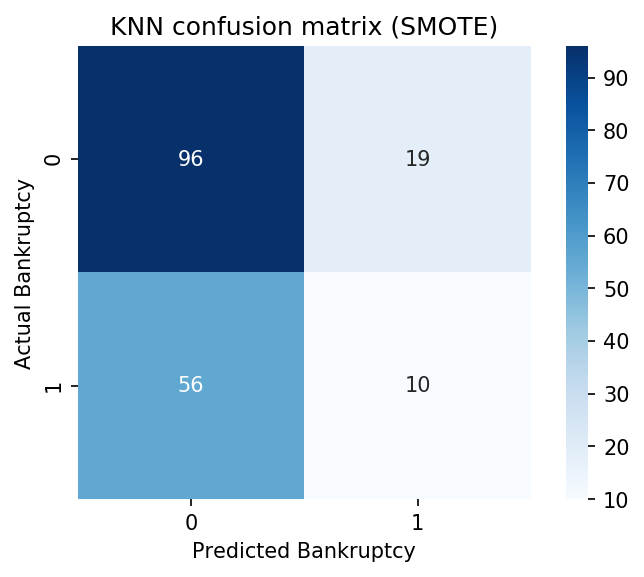

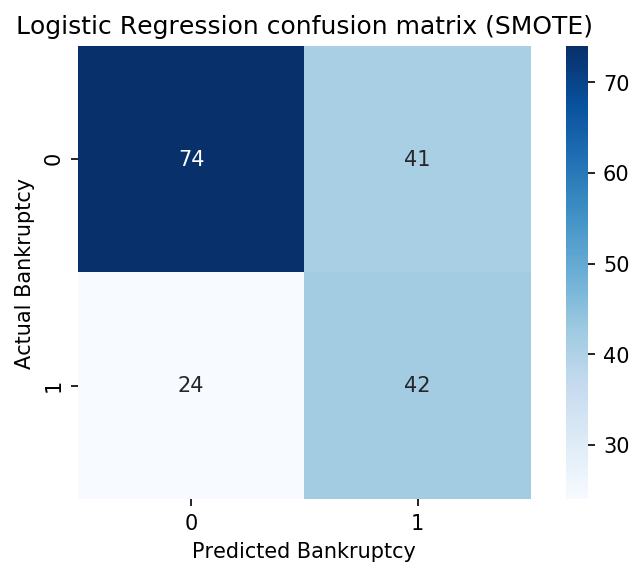

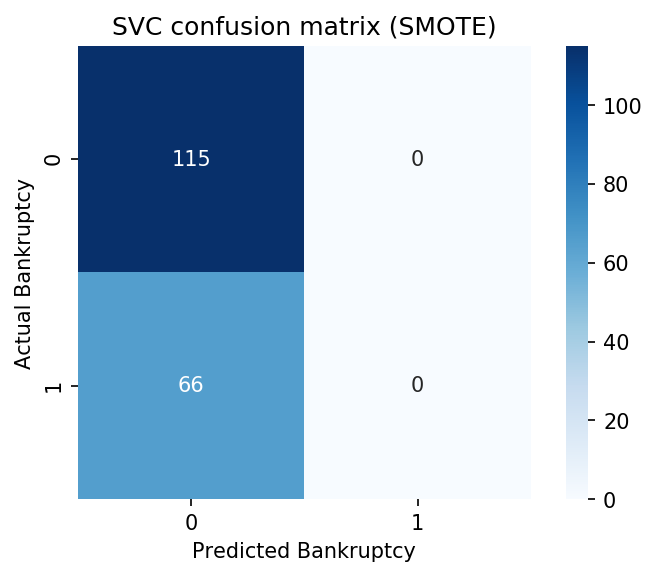

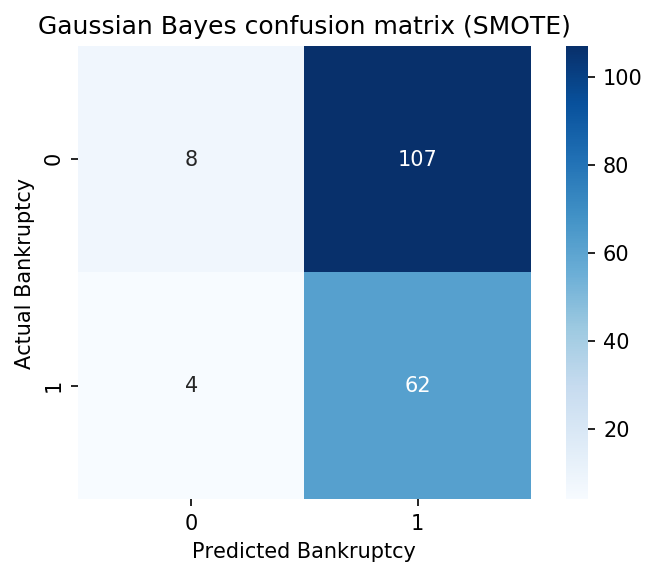

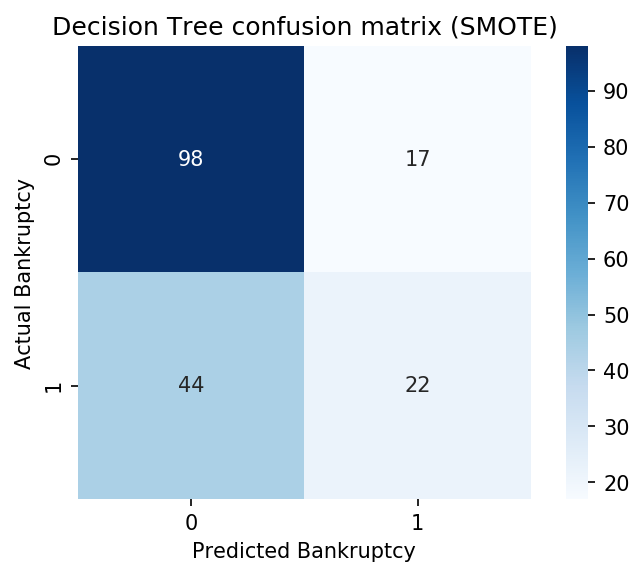

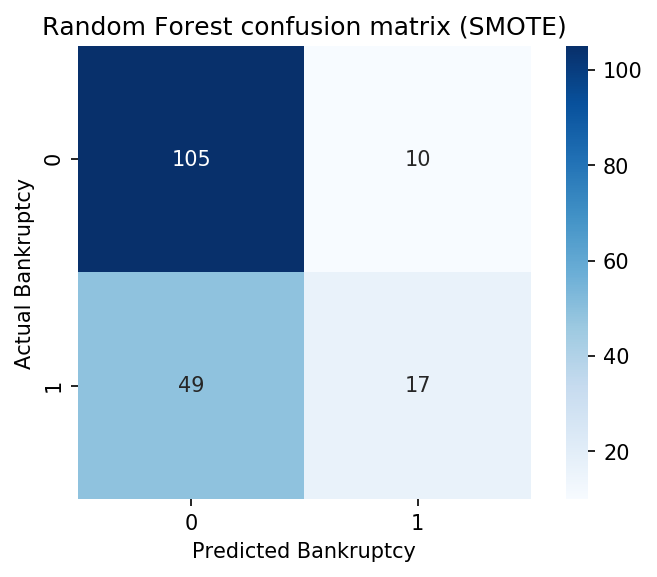

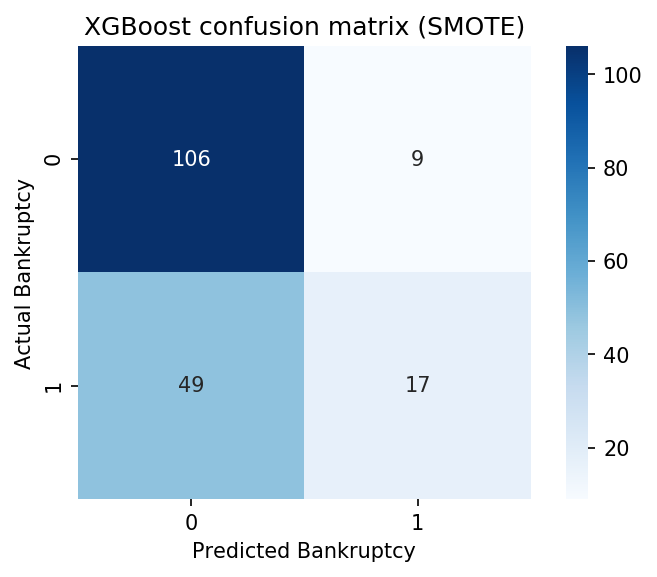

In [135]:
# knn
rf_confusion = confusion_matrix(y_test, knn.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('KNN confusion matrix (SMOTE)');

# Logistic Regression
rf_confusion = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (SMOTE)');

# SVC
rf_confusion = confusion_matrix(y_test, svc_m.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('SVC confusion matrix (SMOTE)');


# Gaussian Naieve Bayes
rf_confusion = confusion_matrix(y_test, gb_m.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Gaussian Bayes confusion matrix (SMOTE)');

# Decisision Tree 
rf_confusion = confusion_matrix(y_test, tree_m.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Decision Tree confusion matrix (SMOTE)');


# Random Forest 
rf_confusion = confusion_matrix(y_test, RF_m.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Random Forest confusion matrix (SMOTE)');



# XGBoost
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (SMOTE)');

# look again but using fewer columns

KNN ROC AUC score =  0.5724637681159421
LR ROC AUC score =  0.6059288537549408
SVC ROC AUC score =  0.7205533596837944
GRM ROC AUC score =  0.5173913043478261
Decision Tree ROC AUC score =  0.5602108036890645
Random Forest ROC AUC score =  0.6519104084321476
XGB ROC AUC score =  0.6519104084321476


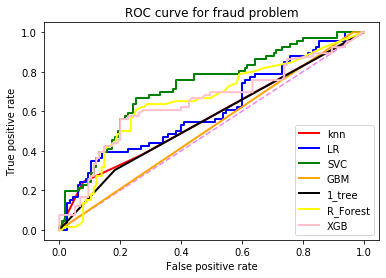

In [137]:
# Try various models with all columns.

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)

###### KNN ########
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train_smote[short_cols], y_train_smote)

train_preds = knn.score(X_train_smote[short_cols], y_train_smote)
test_preds = knn.score(X_test[short_cols], y_test)

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='knn', color='red')
plt.plot([0,1],[0,1],c='violet',ls='--',)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test[short_cols])[:,1]))




###### Logistic Regression ####
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='none', class_weight='balanced', max_iter=10000)

lr.fit(X_train_smote[short_cols], y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='LR' ,color='blue')
print("LR ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test[short_cols])[:,1]))


##### SVC Model ##########
from sklearn.svm import SVC

svc_m = SVC(probability=True)

svc_m.fit(X_train_smote[short_cols], y_train_smote)

y_predict = svc_m.predict(X_test[short_cols])

fpr, tpr, thresholds = roc_curve(y_test, svc_m.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='SVC' ,color='green')
print("SVC ROC AUC score = ", roc_auc_score(y_test, svc_m.predict_proba(X_test[short_cols])[:,1]))


#### Gaussian Naieve Bayes Model #######
from sklearn.naive_bayes import GaussianNB
gb_m = GaussianNB()

gb_m.fit(X_train_smote[short_cols], y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, gb_m.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='GBM' ,color='orange')
print("GRM ROC AUC score = ", roc_auc_score(y_test, gb_m.predict_proba(X_test[short_cols])[:,1]))


## Decision Tree Model #########
from sklearn.tree import DecisionTreeClassifier
tree_m = DecisionTreeClassifier()
tree_m.fit(X_train_smote[short_cols], y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, tree_m.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='1_tree' ,color='black')
print("Decision Tree ROC AUC score = ", roc_auc_score(y_test, tree_m.predict_proba(X_test[short_cols])[:,1]))

##### Random Forest Model #####
from sklearn.ensemble import RandomForestClassifier

RF_m = RandomForestClassifier()

RF_m.fit(X_train_smote[short_cols], y_train_smote)

fpr, tpr, thresholds = roc_curve(y_test, RF_m.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='R_Forest' ,color='Yellow')
print("Random Forest ROC AUC score = ", roc_auc_score(y_test, RF_m.predict_proba(X_test[short_cols])[:,1]))


#### XGB Model ########
xgb = xgboost.XGBClassifier()
xgb.fit(X_train_smote[short_cols],y_train_smote, early_stopping_rounds=500,eval_set=[(X_train_smote[short_cols], y_train_smote), (X_test[short_cols], y_test)],eval_metric='auc',verbose=False )

fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test[short_cols])[:,1])

plt.plot(fpr, tpr,lw=2,label='XGB' ,color='Pink')

plt.legend()
print("XGB ROC AUC score = ", roc_auc_score(y_test, RF_m.predict_proba(X_test[short_cols])[:,1]))


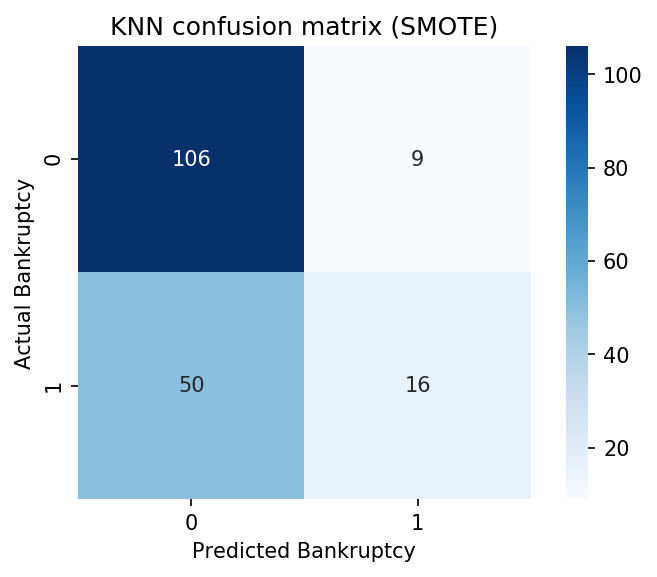

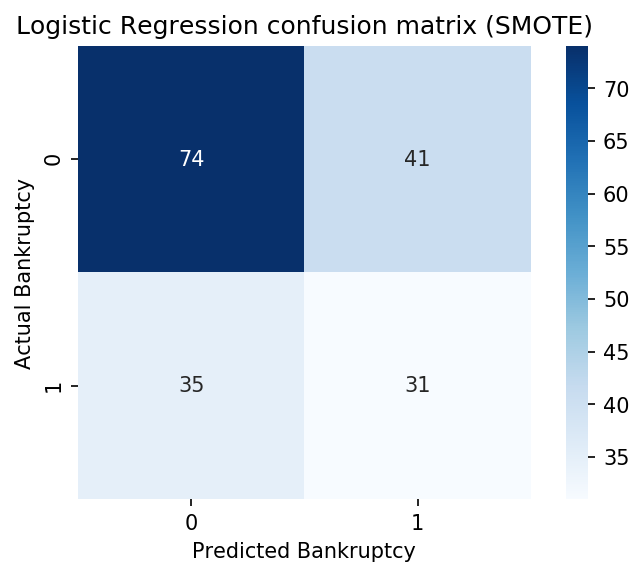

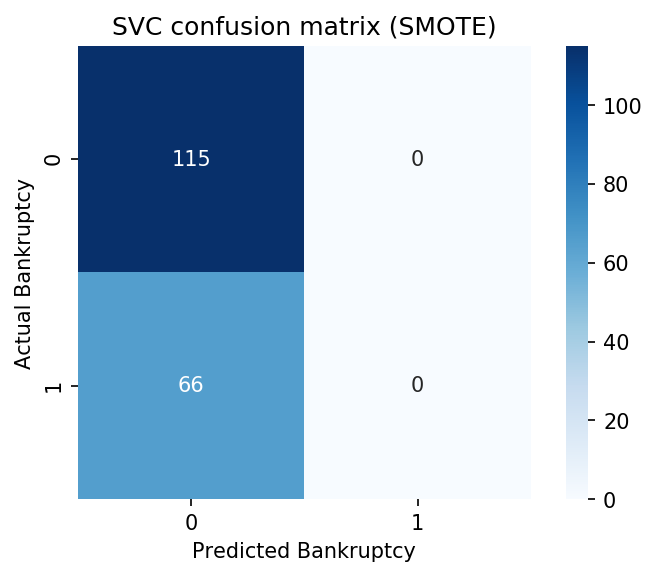

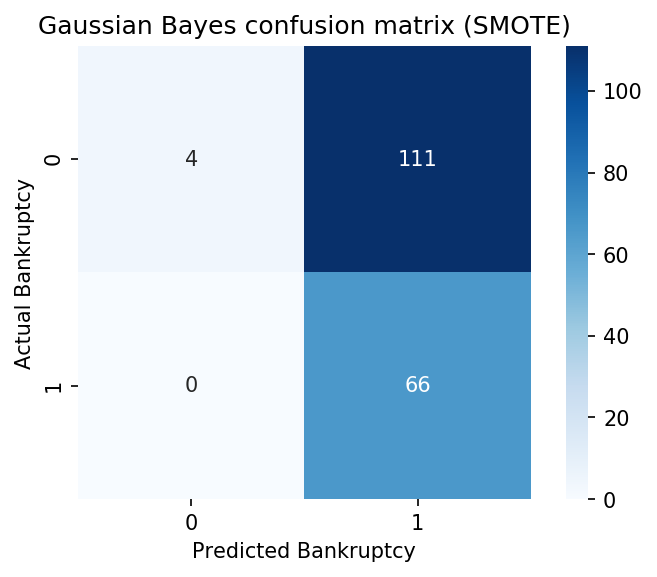

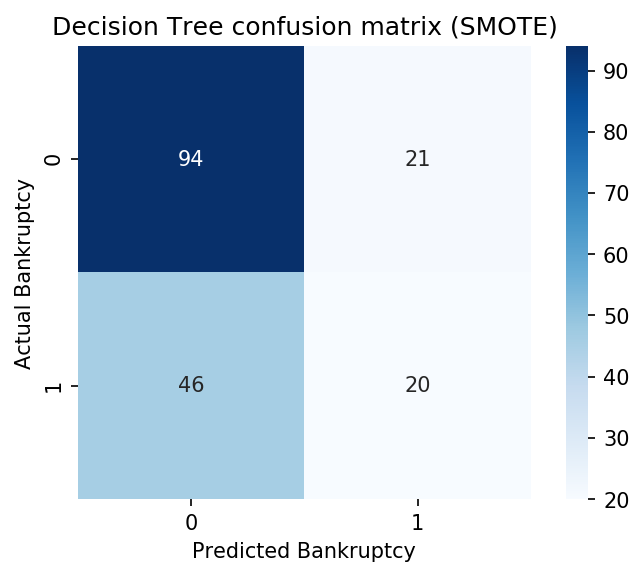

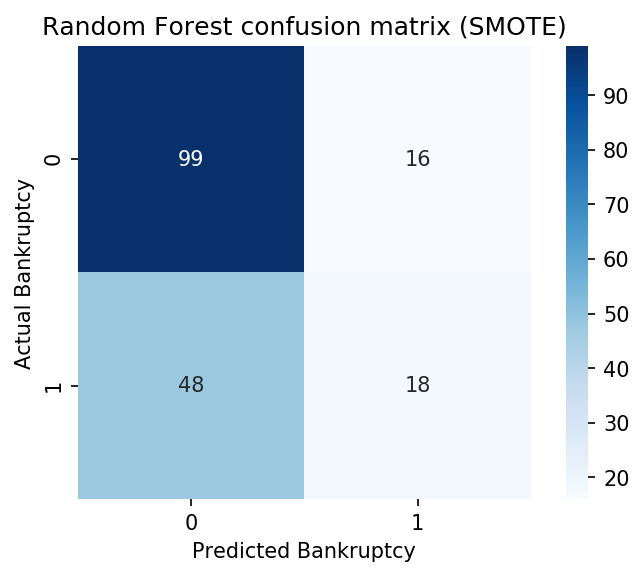

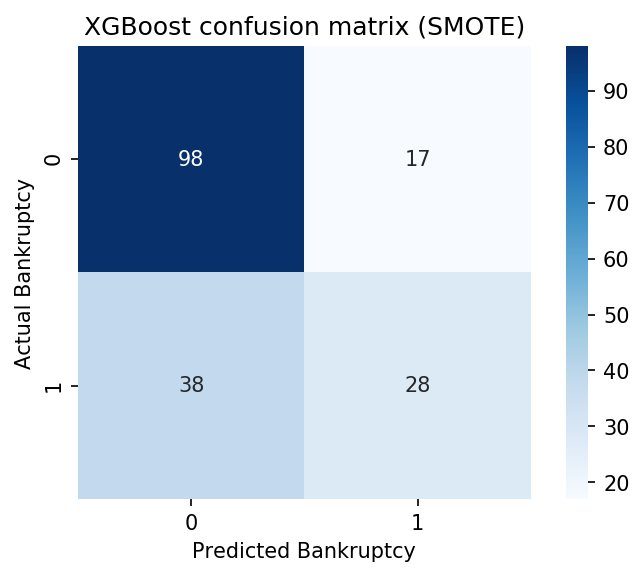

In [138]:
# knn
rf_confusion = confusion_matrix(y_test, knn.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('KNN confusion matrix (SMOTE)');

# Logistic Regression
rf_confusion = confusion_matrix(y_test, lr.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (SMOTE)');

# SVC
rf_confusion = confusion_matrix(y_test, svc_m.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('SVC confusion matrix (SMOTE)');


# Gaussian Naieve Bayes
rf_confusion = confusion_matrix(y_test, gb_m.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Gaussian Bayes confusion matrix (SMOTE)');

# Decisision Tree 
rf_confusion = confusion_matrix(y_test, tree_m.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Decision Tree confusion matrix (SMOTE)');


# Random Forest 
rf_confusion = confusion_matrix(y_test, RF_m.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Random Forest confusion matrix (SMOTE)');



# XGBoost
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test[short_cols]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (SMOTE)');

# Interesting the logistic regression model does fairly well.

I'll use gridsearchcv to play with some settings.

In [155]:
pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1_weighted')

# Fit on data

best_clf = clf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 26.6min finished
Liblinear failed to converge, increase the number of iterations.


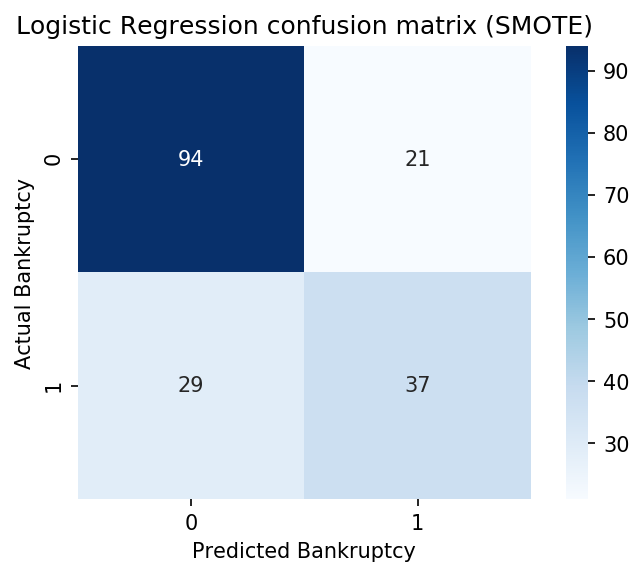

In [130]:
from sklearn.linear_model import LogisticRegression

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)


X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)

lr = LogisticRegression(penalty='elasticnet', class_weight='balanced', max_iter=10000, C=.00026366508987303583, solver='saga',l1_ratio=1)

lr.fit(X_train_smote, y_train_smote)

rf_confusion = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (SMOTE)');

The Logistic Regression model is pretty good, I found the elastic net penalty to do a bit better. I can try and reduce max_iter until we get the same model but faster.

In [204]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='elasticnet', class_weight='balanced', max_iter=5000, C=.00026366508987303583, solver='saga',l1_ratio=1)

lr.fit(X_train_smote, y_train_smote)

rf_confusion = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (SMOTE)')

KeyboardInterrupt: 

# try and optimize an XGB model.

I tried quite a few variations of below, I eventually cut the list to the model that seemed to have the best recall without cutting into precision too much.

In [139]:
over = SMOTE(sampling_strategy=0.08)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)


X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


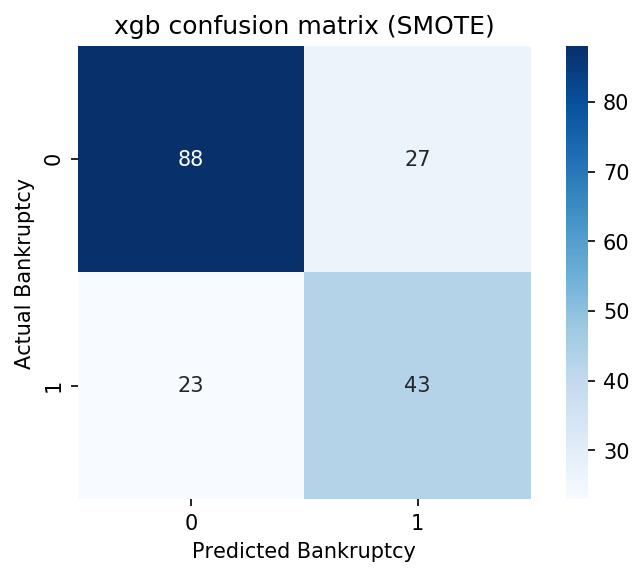

In [203]:

param_dict={'base_score':[.3] ,
 'scale_pos_weight': [10],
 'booster': ['gbtree'],
 'colsample_bylevel': [.7],
 'colsample_bytree': [.9],
 'gamma': [0],
 'learning_rate': [1],
 'max_delta_step': [3],
 'max_depth': [3],
 'min_child_weight': [3],
 'n_estimators': [10000],
 'objective': ['binary:logistic']
           }
clf = GridSearchCV(xgboost.XGBClassifier(), param_grid = param_dict, cv = 5, verbose=True, n_jobs=-1, scoring='recall')


clf.fit(X_train_smote,y_train_smote, early_stopping_rounds=5,eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)],eval_metric='auc',verbose=False )

rf_confusion = confusion_matrix(y_test, clf.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGB confusion matrix (SMOTE)');

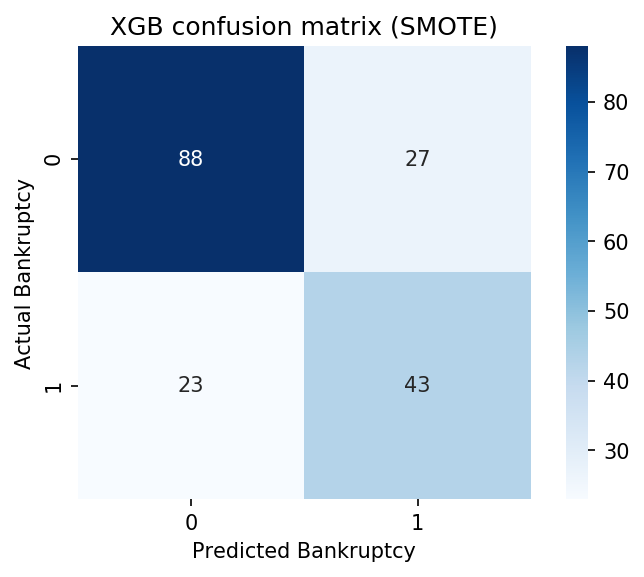

In [202]:

param_dict={'base_score':.3 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': .7,
 'colsample_bytree': .9,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }

xgb=xgboost.XGBClassifier(**param_dict)

xgb.fit(X_train_smote,y_train_smote, early_stopping_rounds=5,eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)],eval_metric='auc',verbose=False )

rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGB confusion matrix (SMOTE)');

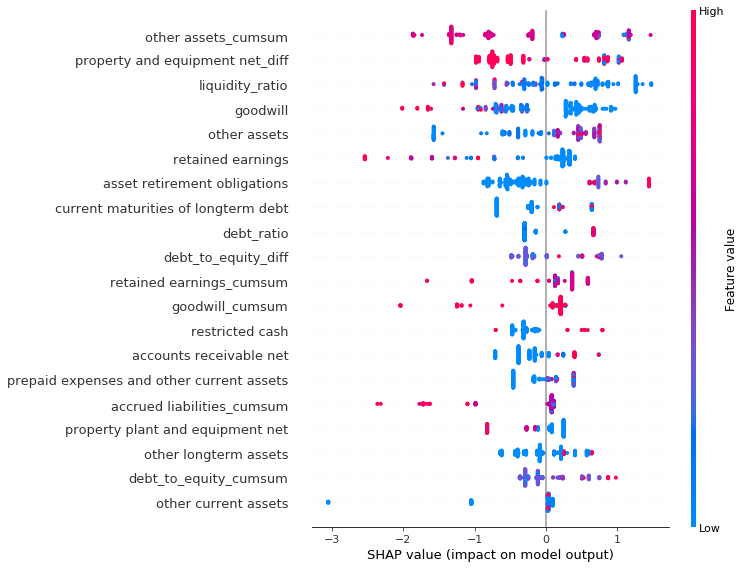

In [163]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Make a new short col list and see if it does anything.

In [164]:
short_cols_10=X_train.columns[sorted_idx[-10:]]
short_cols_20=X_train.columns[sorted_idx[-20:]]
short_cols_30=X_train.columns[sorted_idx[-30:]]

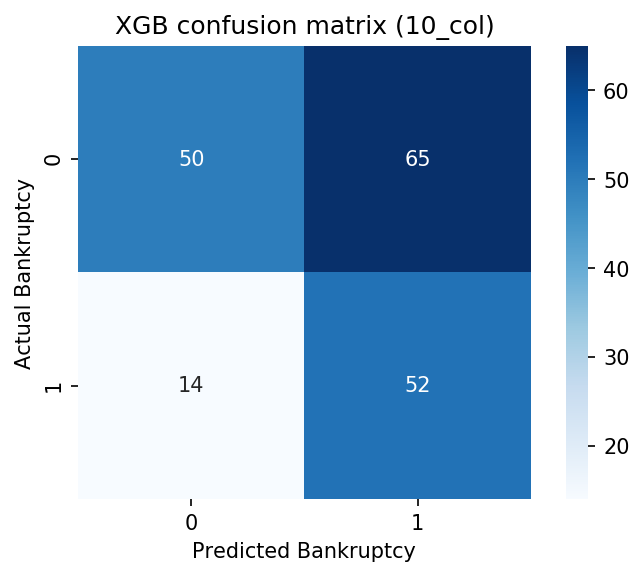

In [182]:
param_dict={'base_score':.3 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': .7,
 'colsample_bytree': .9,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }

xgb=xgboost.XGBClassifier(**param_dict)

xgb.fit(X_train_smote[short_cols_10],y_train_smote, early_stopping_rounds=5,eval_set=[(X_train_smote[short_cols_10], y_train_smote), (X_test[short_cols_10], y_test)],eval_metric='auc',verbose=False )

rf_confusion = confusion_matrix(y_test, xgb.predict(X_test[short_cols_10]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGB confusion matrix (10_col)');

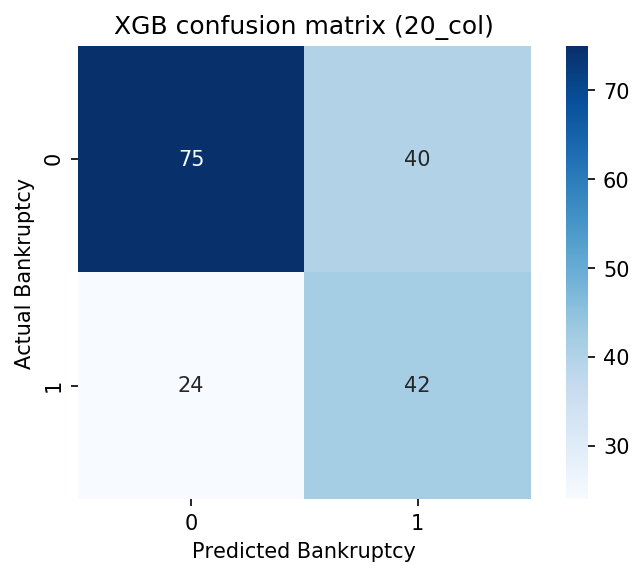

In [186]:
param_dict={'base_score':.3 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': .7,
 'colsample_bytree': .9,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }

xgb=xgboost.XGBClassifier(**param_dict)

xgb.fit(X_train_smote[short_cols_20],y_train_smote, early_stopping_rounds=5,eval_set=[(X_train_smote[short_cols_20], y_train_smote), (X_test[short_cols_20], y_test)],eval_metric='auc',verbose=False )

rf_confusion = confusion_matrix(y_test, xgb.predict(X_test[short_cols_20]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGB confusion matrix (20_col)');

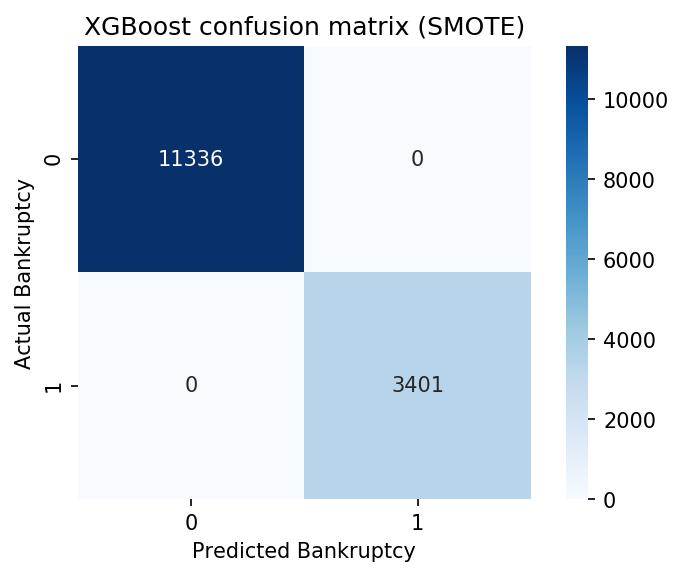

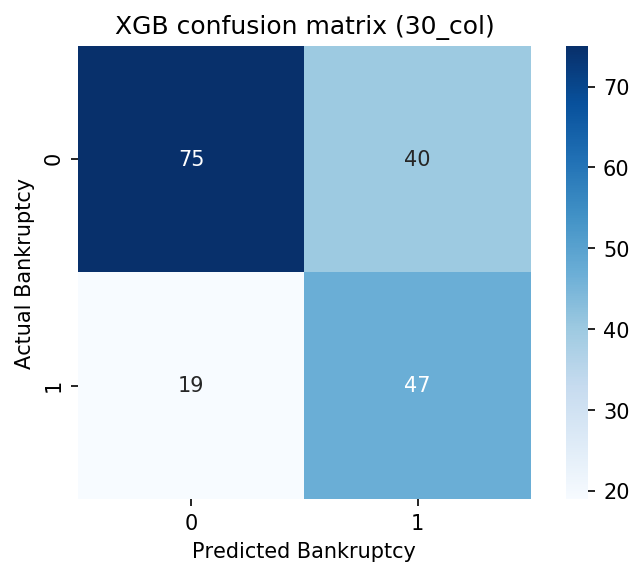

In [240]:
param_dict={'base_score':.5 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': .7,
 'colsample_bytree': .9,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }

xgb=xgboost.XGBClassifier(**param_dict)

xgb.fit(X_train_smote[short_cols_30],y_train_smote, early_stopping_rounds=5,eval_set=[(X_train_smote[short_cols_30], y_train_smote), (X_test[short_cols_30], y_test)],eval_metric='auc',verbose=False )

xgb_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote[short_cols_30]))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (SMOTE)');

rf_confusion = confusion_matrix(y_test, xgb.predict(X_test[short_cols_30]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGB confusion matrix (30_col)');

#### It seems like the fewer columns are somewhat helpful. Lets try using them on the LR model.

Text(0.5, 1, 'Logistic Regression confusion matrix (SMOTE)')

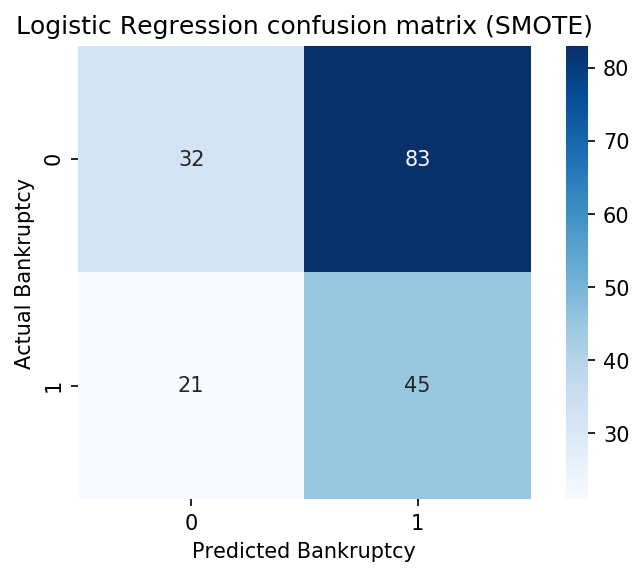

In [205]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='elasticnet', class_weight='balanced', max_iter=5000, C=.00026366508987303583, solver='saga',l1_ratio=1)

lr.fit(X_train_smote[short_cols_10], y_train_smote)

rf_confusion = confusion_matrix(y_test, lr.predict(X_test[short_cols_10]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (10 col)')

The max_iter was reached which means the coef_ did not converge


Text(0.5, 1, 'Logistic Regression confusion matrix (SMOTE)')

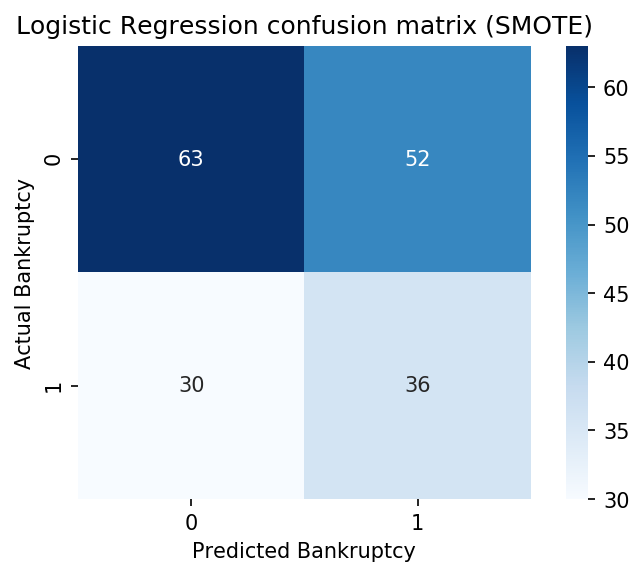

In [206]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='elasticnet', class_weight='balanced', max_iter=5000, C=.00026366508987303583, solver='saga',l1_ratio=1)

lr.fit(X_train_smote[short_cols_20], y_train_smote)

rf_confusion = confusion_matrix(y_test, lr.predict(X_test[short_cols_20]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (20 col)')

The max_iter was reached which means the coef_ did not converge


Text(0.5, 1, 'Logistic Regression confusion matrix (30 col)')

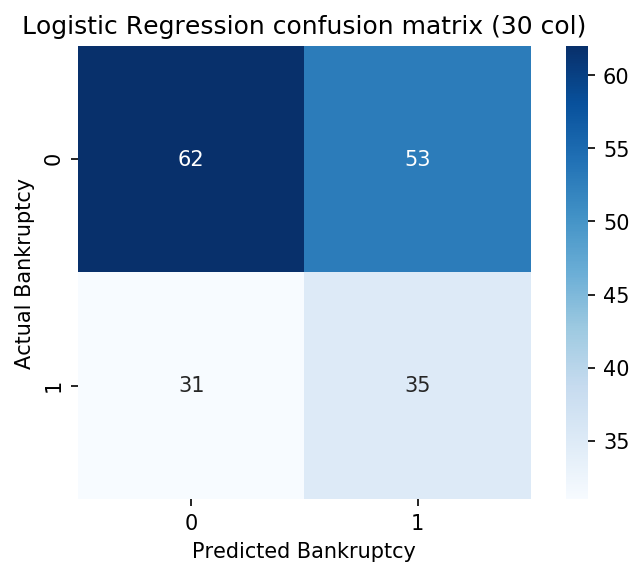

In [210]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='elasticnet', class_weight='balanced', max_iter=5000, C=.00026366508987303583, solver='saga',l1_ratio=1)

lr.fit(X_train_smote[short_cols_30], y_train_smote)

rf_confusion = confusion_matrix(y_test, lr.predict(X_test[short_cols_30]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (30 col)')

# Try models on holdout

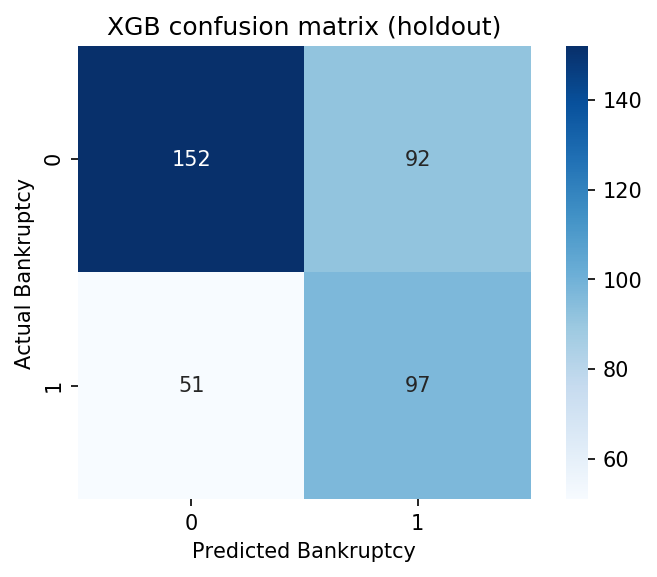

In [201]:
holdout=holdout.fillna(0)
rf_confusion = confusion_matrix(holdout['bankruptcy_1_yr'], xgb.predict(holdout[short_cols_30]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGB confusion matrix (holdout)');

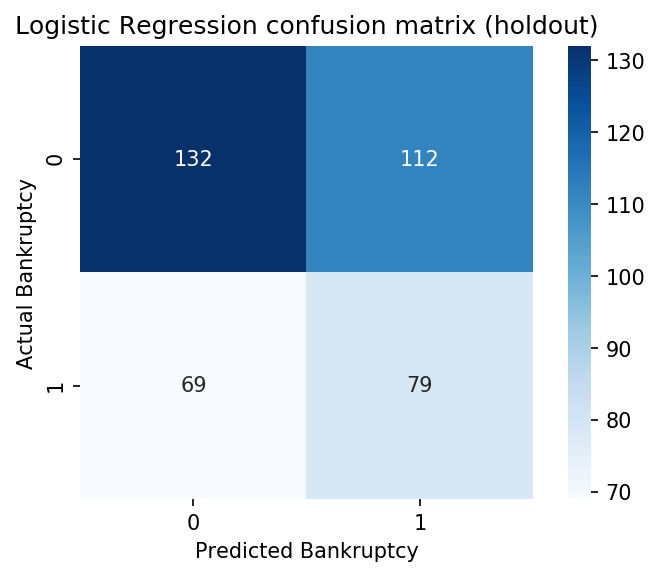

In [208]:
rf_confusion = confusion_matrix(holdout['bankruptcy_1_yr'], lr.predict(holdout[short_cols_30]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (holdout)');

# Conclusions

Unfortunately the final product falls a little bit short of anything too impressive. I think there is a lot of issues with the data to be overcome. Using the 30 column XGB model though we were able to get an ok prediction on the holdout data.

In [212]:
holdout['predicted'] =  xgb.predict(holdout[short_cols_30])

In [232]:
holdout["Name"].unique()

array(['Akorn, Inc.', 'Stage Stores, Inc. (2020)',
       'Briggs & Stratton Corporation',
       'Frontier Communications Corporation', 'Pier 1 Imports, Inc.',
       'Valaris plc', 'Pioneer Energy Services Corp.',
       'McDermott International, Inc.', 'Unit Corporation',
       'CEC Entertainment, Inc.', 'Centric Brands Inc.',
       'Tuesday Morning Corporation', 'Tailored Brands, Inc.',
       'Stein Mart, Inc.', 'Chesapeake Energy Corporation', 'Libbey Inc.',
       'Pyxus International, Inc.', 'Denbury Resources Inc.',
       'Diamond Offshore Drilling, Inc.', 'CARBO Ceramics, Inc.',
       'J. Crew Group, Inc.', 'McClatchy Company', 'Internap Corporation',
       'Hornbeck Offshore Services, Inc.', 'RTW Retailwinds, Inc.',
       'Whiting Petroleum Corporation',
       'Town Sports International Holdings, Inc. (TSI, LLC only)',
       'Neiman Marcus Group LTD LLC',
       'Hertz Global Holdings, Inc. (Hertz Corporation)',
       'Noble Corporation plc', 'Oasis Petroleum Inc.',

# Look at J-Crew as an example.

In [234]:
holdout[holdout.Name=='J. Crew Group, Inc.'][['CIK','Name','Filings','Filing Date','predicted','bankruptcy_1_yr','d_to_bankruptcy']]

,CIK,Name,Filings,Filing Date,predicted,bankruptcy_1_yr,d_to_bankruptcy
19931,1051251,"J. Crew Group, Inc.",10-K,2018-03-27,0,0,769.0
19932,1051251,"J. Crew Group, Inc.",10-K,2019-03-20,1,0,411.0
19933,1051251,"J. Crew Group, Inc.",10-Q,2018-05-30,0,0,705.0
19934,1051251,"J. Crew Group, Inc.",10-Q,2018-08-28,1,0,615.0
19935,1051251,"J. Crew Group, Inc.",10-Q,2018-11-29,1,0,522.0
19936,1051251,"J. Crew Group, Inc.",10-Q,2019-05-29,1,1,341.0
19937,1051251,"J. Crew Group, Inc.",10-Q,2019-09-13,1,1,234.0
19938,1051251,"J. Crew Group, Inc.",10-Q,2019-12-02,1,1,154.0


It seems the model felt J-Crew was looking bad back in August of 2018 and continued to flag it as we moved closer to their filing in 2020.

# Last look at all of the data and store it for use in an app.

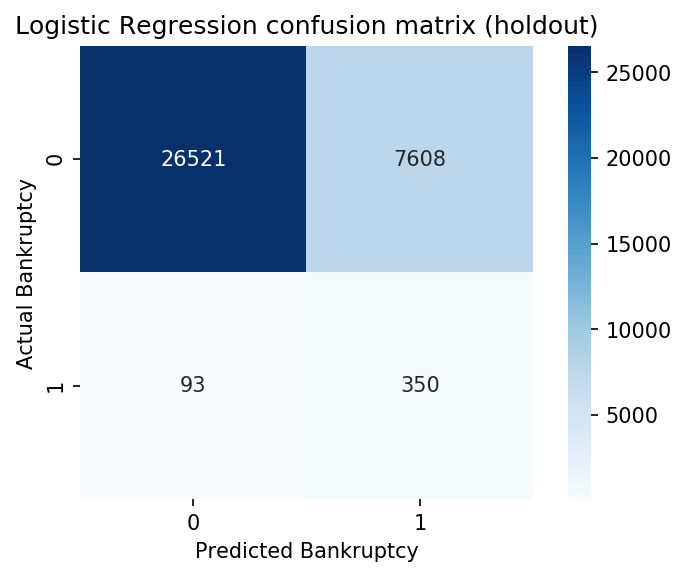

In [241]:
base_dat=base_dat.fillna(0)

rf_confusion = confusion_matrix(base_dat['bankruptcy_1_yr'], xgb.predict(base_dat[short_cols_30]))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Logistic Regression confusion matrix (holdout)');

In the end the model did not work as well as I had hoped, unfortunately I think just too much data is missing.

In [243]:
base_dat['predicted'] =  xgb.predict(base_dat[short_cols_30])

In [248]:
mask = (base_dat['predicted']==1) & (base_dat['d_to_bankruptcy']==0)
base_dat[mask][['CIK','Name','Filings','Filing Date','predicted','bankruptcy_1_yr','d_to_bankruptcy']].head(30)

,CIK,Name,Filings,Filing Date,predicted,bankruptcy_1_yr,d_to_bankruptcy
1,1750,Aar Corp,10-K,2015-07-15,1,0,0.0
29,1800,Abbott Laboratories,10-K,2015-02-27,1,0,0.0
30,1800,Abbott Laboratories,10-K,2016-02-19,1,0,0.0
31,1800,Abbott Laboratories,10-K,2017-02-17,1,0,0.0
36,1800,Abbott Laboratories,10-Q,2014-05-07,1,0,0.0
37,1800,Abbott Laboratories,10-Q,2014-08-05,1,0,0.0
38,1800,Abbott Laboratories,10-Q,2014-11-06,1,0,0.0
39,1800,Abbott Laboratories,10-Q,2015-05-06,1,0,0.0
41,1800,Abbott Laboratories,10-Q,2015-11-05,1,0,0.0
42,1800,Abbott Laboratories,10-Q,2016-05-04,1,0,0.0


In [252]:
base_dat[base_dat.Name=='Abbott Laboratories'][short_cols_30]

,common stock,current portion of longterm debt_cumsum,other noncurrent liabilities,total stockholders equity_cumsum,assets held for sale_cumsum,property and equipment net_cumsum,preferred stock,total stockholders’ equity_cumsum,deferred revenue,current portion of longterm debt_diff,...,asset retirement obligations,current portion of longterm debt,retained earnings_cumsum,total assets_cumsum,retained deficit_diff,accumulated deficit,current liabilities,retained earnings_diff,other assets_cumsum,accumulated deficit_diff
28,0.0,0.000,6503.5000,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,...,0.0,9.000,0.0,0.000,0.0,0.0,9507.000,0.0,0.000,0.0
29,0.0,46.000,6737.5000,0.0,0.0,-104.0000,0.0,0.0,0.0,46.000,...,0.0,55.000,0.0,-2832.000,0.0,0.0,10532.000,0.0,-1678.000,0.0
30,0.0,-6.000,6114.5000,0.0,0.0,-331.0000,0.0,0.0,0.0,-52.000,...,0.0,3.000,0.0,-3399.000,0.0,0.0,9186.000,0.0,-1706.000,0.0
31,0.0,-6.000,4620.5000,0.0,0.0,-352.0000,0.0,0.0,0.0,0.000,...,0.0,3.000,0.0,8621.000,0.0,0.0,6660.000,0.0,9713.000,0.0
32,0.0,499.000,6361.5000,0.0,0.0,2048.5000,0.0,0.0,0.0,505.000,...,0.0,508.000,0.0,17098.500,0.0,0.0,8912.000,0.0,33297.000,0.0
33,0.0,-2.000,6396.0000,0.0,0.0,2247.0000,0.0,0.0,0.0,-501.000,...,0.0,7.000,0.0,9802.500,0.0,0.0,9012.000,0.0,24220.000,0.0
34,0.0,1268.000,7449.0000,0.0,0.0,3031.0000,0.0,0.0,0.0,1270.000,...,0.0,1277.000,0.0,10677.000,0.0,0.0,10863.000,0.0,24934.000,0.0
35,0.0,0.000,7556.0685,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,...,0.0,264.009,0.0,0.000,0.0,0.0,11331.665,0.0,0.000,0.0
36,0.0,-256.009,6793.5000,0.0,0.0,198.2155,0.0,0.0,0.0,-256.009,...,0.0,8.000,0.0,-2144.213,0.0,0.0,10186.000,0.0,-2470.477,0.0
37,0.0,-255.009,6550.0000,0.0,0.0,237.2155,0.0,0.0,0.0,1.000,...,0.0,9.000,0.0,-2074.213,0.0,0.0,9853.000,0.0,-2657.477,0.0


In [254]:
base_dat.to_pickle('FINAL_data_for_app.pkl')